# Thermal Wind Example
By: Kevin Goebbert

Date: 5 April 2017

In [1]:
def get_lonlat(x,y,dproj):
    from pyproj import Proj

    p = Proj(proj='lcc', ellps='sphere',
             lon_0=dproj.longitude_of_central_meridian,
             lat_0=dproj.latitude_of_projection_origin,
             lat_1=dproj.GRIB_param_Latin1,
             lat_2=dproj.GRIB_param_Latin2,
             a=dproj.earth_radius,
             b=dproj.earth_radius)

    return p(x,y,inverse=True)

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import xarray as xr
from netCDF4 import num2date
import scipy.ndimage as ndimage
from datetime import datetime
from siphon.ncss import NCSS
from metpy.units import units
from metpy.calc import geostrophic_wind, coriolis_parameter

In [3]:
year = '2014'
month = '03'
day = '08'
hour = '18'

data = xr.open_dataset('https://nomads.ncdc.noaa.gov/thredds/dodsC/namanl/'+year+month+'/'+year+month+day+'/'+
                       'namanl_218_'+year+month+day+'_'+hour+'00_000.grb',
                       decode_times=True)
#print(sorted(list(data.variables)))

In [4]:
print(sorted(list(data.variables)))

['Absolute_vorticity', 'Accumulated_snow', 'Accumulated_snow_Accumulation', 'Albedo', 'Best_4-layer_lifted_index', 'Blackadars_mixing_length_scale', 'Categorical_freezing_rain', 'Categorical_ice_pellets', 'Categorical_rain', 'Categorical_snow', 'Convective_Avail_Pot_Energy', 'Convective_Avail_Pot_Energy_surface', 'Convective_inhibition', 'Convective_inhibition_surface', 'Convective_precipitation', 'Derived_radar_reflectivity', 'Derived_radar_reflectivity_hybrid', 'Dew_point_temperature', 'Direct_evaporation_cease_soil_moisture', 'Downward_long_wave_flux', 'Downward_short_wave_flux', 'Drag_coefficient', 'Friction_velocity', 'Geometric_vertical_velocity', 'Geopotential_height', 'Geopotential_height_Unknown220', 'Geopotential_height_lowest_level_of_wet_bulb_zero', 'Geopotential_height_surface', 'Geopotential_height_zeroDegC_isotherm', 'Ice_concentration_ice1no_ice0', 'Lambert_Conformal', 'Land_cover_land1sea0', 'Latent_heat_flux', 'Lightning', 'Liquid_volumetric_soil_moisture_non-frozen',

In [5]:
print(data.Geopotential_height.coords)

Coordinates:
  * time       (time) datetime64[ns] 2014-03-08T18:00:00
  * y          (y) float64 -832.7 -820.5 -808.3 -796.1 -783.9 -771.7 -759.6 ...
  * x          (x) float64 -4.226e+03 -4.214e+03 -4.202e+03 -4.19e+03 ...
  * isobaric1  (isobaric1) float64 1e+03 975.0 950.0 925.0 900.0 875.0 850.0 ...


In [6]:
# X, Y values are in units of km, need them in meters for plotting/calculations
data.x.values = data.x.values*1000.
data.y.values = data.y.values*1000.

# Make them 2D for plotting/calculations
x, y = np.meshgrid(data.x.values,data.y.values)

In [7]:
# Get the valid times from the file
vtimes = []
for t in range(data.time.size):
    vtimes.append(datetime.utcfromtimestamp(data.time[t].data.astype('O')/1e9))
print(vtimes)

[datetime.datetime(2014, 3, 8, 18, 0)]


In [8]:
hght_1000 = data.Geopotential_height.sel(time=vtimes[0], isobaric1=1000)
hght_500 = data.Geopotential_height.sel(time=vtimes[0], isobaric1=500)

thick_1000_500 = ndimage.gaussian_filter((hght_500.data - hght_1000.data),sigma=5) * units.meters

_, dx = np.gradient(x) * units.meters
dy, _ = np.gradient(y) * units.meters

lon, lat = get_lonlat(x,y,data.Lambert_Conformal)

f = coriolis_parameter(lat*units.degree).to('1/s')

u_thmw, v_thmw = geostrophic_wind(thick_1000_500.T, f.T, dx.T, dy.T)
u_thmw = u_thmw.T
v_thmw = v_thmw.T

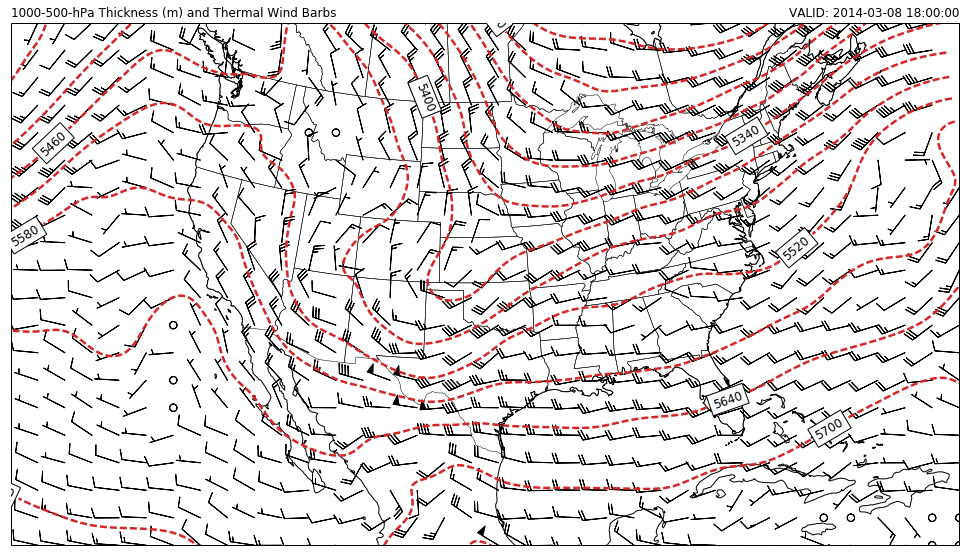

In [9]:
%matplotlib inline
datacrs = ccrs.LambertConformal(central_latitude=data.Lambert_Conformal.latitude_of_projection_origin,
                                central_longitude=data.Lambert_Conformal.longitude_of_central_meridian)
plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                standard_parallels=[30,60])

#crs = ccrs.PlateCarree()
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lakes',
        scale='50m',
        facecolor='none')

fig = plt.figure(1,figsize=(17.,11.))
ax  = plt.axes(projection=plotcrs)
ax.coastlines('50m',edgecolor='black')
ax.add_feature(states_provinces,edgecolor='black',linewidth=0.5)
ax.set_extent([-130,-67,20,50],ccrs.PlateCarree())


clev500 = np.arange(5100,6000,60)
cs = ax.contour(x,y,ndimage.gaussian_filter(thick_1000_500,sigma=5),clev500,
                colors='tab:red',linewidths=2.5,linestyles='dashed',
                transform=datacrs)
tl = plt.clabel(cs, fontsize=12, colors='k',inline=1, inline_spacing=8, 
                fmt='%i', rightside_up=True, use_clabeltext=True)
for t in tl: 
    t.set_bbox(dict(fc="w")) 

# Transform Vectors before plotting, then plot wind barbs.
ax.barbs(x,y,u_thmw.m,v_thmw.m,length=7,regrid_shape=20,transform=datacrs)

# Add some titles to make the plot readable by someone else
plt.title('1000-500-hPa Thickness (m) and Thermal Wind Barbs',loc='left')
plt.title('VALID: %s' %(vtimes[0]),loc='right')


plt.show()